# Purpose: Design and Solve a Bayesian Problem

## Requirements

    *At least one continuous random variable
    *Clear Description of Problem
    *Mathematical Model
    *Code to solve problem
    *Present Results
    *Conclusions from problem

## Problem Description

## Bayesian Sensor for Determining When Someone is in Bed

Prior: Gaussian

Evidence: 
        
        * Phone plugged in (true/false)
        * Time since last motion in house (continuous)
        * Bedroom light on (true/false)
        
        

In [2]:
import pandas as pd
import numpy as np

from scipy import stats

import pymc3 as pm
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib

import json
# s = json.load(open('style/bmh_matplotlibrc.json'))
# matplotlib.rcParams.update(s)

matplotlib.rcParams['figure.figsize'] = (10, 3)
matplotlib.rcParams['font.size'] = 14


In [4]:
def prior(time, mu = 240, sigma=360):
    z_score = (time - mu) / sigma
    probability = stats.norm.cdf(z_score) if (z_score) < 0 else (1 - stats.norm.cdf(z_score))
    x_values = np.linspace(-3 * sigma + mu, 3 * sigma + mu, 1e4)
    y_values = stats.norm.pdf(x_values, loc=mu, scale=sigma)
    plt.plot(x_values, y_values); plt.title('Mean = %d, Standard Deviation = %d' % (mu, sigma))
    plt.vlines(time, ymin=min(y_values), ymax=max(y_values))
    plt.show();
    return probability

In [5]:
def chain_rule():
    pass

In [6]:
def update_probability(phone, time, light):
    numerator = 0
    denominator = 0 
    pass

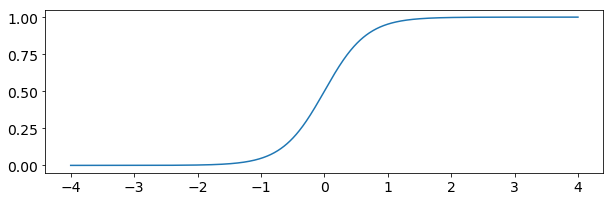

In [7]:
def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * -x))

x = np.linspace(-4, 4, 1000)
plt.plot(x, logistic(x, 3))

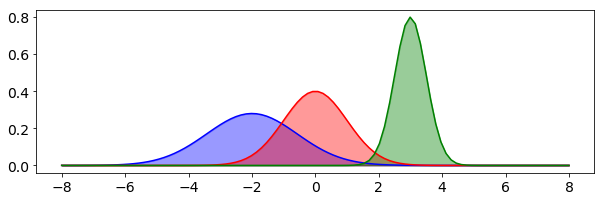

In [8]:
nor = stats.norm
x = np.linspace(-8, 8, 100)
mu = (-2, 0, 3)
tau = (0.7, 1, 2)
colors = ['blue', 'red', 'green']
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1./_tau), color = _color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1/_tau), color = _color, alpha = 0.4)
    


# Wake Sleep Data

Find distribution of wake and sleep times from data.

In [9]:
data = pd.read_csv('data/sleep_wake.csv')
data.set_index('Date', inplace=True, drop=True)
data.index=data.index.to_datetime(dayfirst=False)
data = data.ix[:, 0:2]

In [10]:
data['Sleep_time'] = [entry[0] + pd.DateOffset(minutes=entry[1], hours=22) for entry in zip(data.index, data['Sleep'])]

In [11]:
data['Wake_time'] = [entry[0] + pd.DateOffset(minutes=entry[1], hours=6) for entry in zip(data.index, data['Wake'])]

In [12]:
data.head()

,Sleep,Wake,Sleep_time,Wake_time
2017-12-05,15,0,2017-12-05 22:15:00,2017-12-05 06:00:00
2017-12-06,11,0,2017-12-06 22:11:00,2017-12-06 06:00:00
2017-12-07,10,0,2017-12-07 22:10:00,2017-12-07 06:00:00
2017-12-08,21,12,2017-12-08 22:21:00,2017-12-08 06:12:00
2017-12-09,2,0,2017-12-09 22:02:00,2017-12-09 06:00:00


In [13]:
sleep_index = pd.date_range(start=min(data.index), end=max(data.index), freq='60S')
sleep_index = [time for time in sleep_index if (time.hour >= 21) & (time.hour <= 22)]
sleep_data = pd.DataFrame(0, columns=['indicator'], index=sleep_index)

In [14]:
for time in sleep_data.index:
    for sleep_time in data['Sleep_time']:
        if time == sleep_time:
            selected_date = time.date()
            date_subset = [date for date in sleep_data.index if date.date() == selected_date]
            asleep_times = [time for time in date_subset if time.time() >= sleep_time.time()]
            sleep_data.ix[asleep_times, 'indicator'] = 1

In [15]:
np.sum(sleep_data['indicator'])

3050

In [16]:
wake_index=pd.date_range(start=min(data.index), end=max(data.index), freq='60S')
wake_index = [time for time in wake_index if (time.hour <= 6) & (time.hour >= 5)]
wake_data = pd.DataFrame(0, columns=['indicator'], index=wake_index)

In [17]:
for time in wake_data.index:
    for wake_time in data['Wake_time']:
        if time == wake_time:
            selected_date = time.date()
            date_subset = [date for date in wake_data.index if date.date() == selected_date]
            wake_times = [time for time in date_subset if time.time() >= wake_time.time()]
            wake_data.ix[wake_times, 'indicator'] = 1

In [18]:
np.sum(wake_data['indicator'])

3209

In [19]:
sleep_data['time_offset'] = [int((time.hour * 60 + time.minute) - (22*60)) for time in sleep_data.index]

In [20]:
wake_data['time_offset'] = [int((time.hour * 60 + time.minute) - (6 * 60)) for time in wake_data.index]

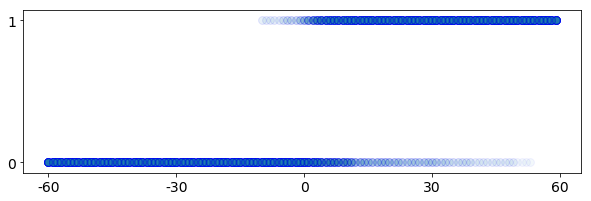

In [62]:
plt.scatter(sleep_data['time_offset'], sleep_data['indicator'], s= 60, alpha=0.05, edgecolors='b')
plt.yticks([0, 1], [0, 1]);
plt.xticks([-60, -30, 0, 30, 60], [-60, -30, 0, 30, 60]);

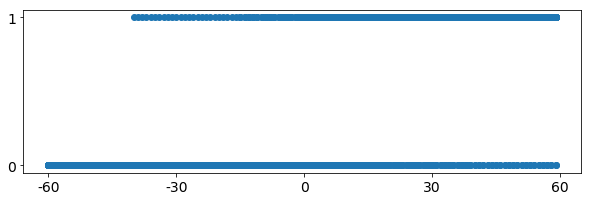

In [23]:
plt.plot(wake_data['time_offset'], wake_data['indicator'], 'o');
plt.yticks([0, 1], [0, 1]);
plt.xticks([-60, -30, 0, 30, 60], [-60, -30, 0, 30, 60]);

In [24]:
time_offset = sleep_data['time_offset']
D = sleep_data['indicator']

In [45]:
with pm.Model() as sleep_model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta* time_offset + alpha)))

In [46]:
with sleep_model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(100, step=step, start=start)
    burned_trace = trace[::2]

logp = -4,916.2, ||grad|| = 1.0006e+05: 100%|██████████| 5/5 [00:00<00:00, 286.69it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
The number of effective samples is smaller than 10% for some parameters.


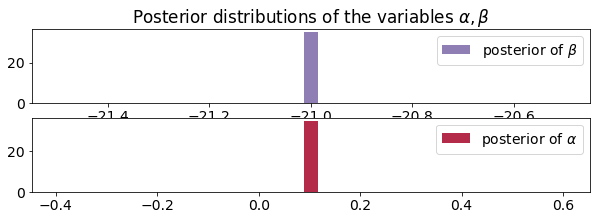

In [47]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]


#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

In [38]:
t = np.linspace(time_offset.min(), time_offset.max(), 50)[:, None]
p_t = logistic(t.T, beta_samples)

mean_prob_t = p_t.mean(axis=0)

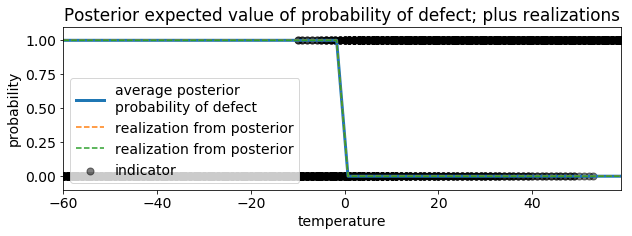

In [41]:

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(time_offset, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

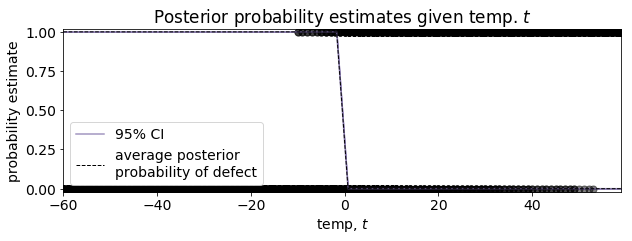

In [43]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(time_offset, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");